# LeNet-5-Quantized

In this notebook, i want to demonstrate how i built LeNet-5 in PyTorch and Quantize it for visualization.


> Network details in this [Blog post ](https://engmrk.com/lenet-5-a-classic-cnn-architecture/) and architecture view can be found below.


![alt text](https://miro.medium.com/max/2625/1*1TI1aGBZ4dybR6__DI9dzA.png)


# Requirments


*   PyTorch (torch)
*   torchvision
*   numpy
*   pillow (PIL)



In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from PIL import Image


# MNIST Dataset

We will download the dataset with `torchvision` and add to it some transforms like padding so the size of the input images become 32x32.

We then split the data to `train_data` and `test_data` randomly.

We make another split in the training data for validation purposes using `SubsetRandomSampler`.



In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
#  validation sample
valid_sample = 0.2

transform = [transforms.Pad(2), transforms.ToTensor()]

# choose the training and test datasets
train_data = datasets.MNIST(root='data',
                            train=True,
                            download=True,
                            transform=transforms.Compose(transform))
test_data = datasets.MNIST(root='data',
                           train=False,
                           download=True,
                           transform=transforms.Compose(transform))

# Creating validation sampler
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_sample * num_train)
train_idx, valid_idx = indices[split:], indices[:split]

# define sampler for batches
trainSampler = SubsetRandomSampler(train_idx)
validationSampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=trainSampler,
                          num_workers=num_workers)
validation_loader = DataLoader(train_data,
                               batch_size=batch_size,
                               sampler=validationSampler,
                               num_workers=num_workers)
test_loader = DataLoader(test_data,
                         batch_size=batch_size,
                         num_workers=num_workers)


# LeNet-5 Network

We inherited form `nn.Module` to construct the LeNet-5 architecture in two steps


1.   initialization of layers in `__init__`
2.   connecting layers to build the pipeline of the network in `forward`



In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 32 x 32 x 1
        self.conv1 = nn.Conv2d(1, 6, (5, 5), padding=0, stride=1)
        # 28 x 28 x 6
        self.pool1 = nn.AvgPool2d((2, 2), stride=2)
        # 14 x 14 x 6
        self.conv2 = nn.Conv2d(6, 16, (5, 5), padding=0, stride=1)
        # 10 x 10 x 16
        self.pool2 = nn.AvgPool2d((2, 2), stride=2)
        # 5 x 5 x 16
        self.conv3 = nn.Conv2d(16, 120, (5, 5), padding=0, stride=1)
        # 1 x 1 x 120
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = self.pool1(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool2(x)
        x = torch.tanh(self.conv3(x))
        # Choose either view or flatten (as you like)
        x = x.view(x.size(0), -1)
        # x = torch.flatten(x, start_dim=1)
        x = torch.tanh(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

model = LeNet()
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


# Configurations

Here, we configure the loss function to be `CrossEntropyLoss` and the optimizer to be Stochastic Gradient Descent (`SGD`).

In [0]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Number of epochs
n_epochs=40

# classes of MNIST
classes = list(range(10))

# Training & Validation

We first check if a GPU is available so i can transfer the learning to it then,  we put the model in training mode and after every epoch we put the model to `eval` mode so we check the validataion loss is getting better or not to save it in `model.pt`.

In [7]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

valid_loss_min = np.Inf

for epoch in range(n_epochs):

    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()  # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.to(device))
        # calculate the loss
        loss = criterion(output, target.to(device))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)

    model.eval()
    for data, target in validation_loader:
        output = model(data.to(device))
        loss = criterion(output, target.to(device))
        valid_loss += loss.item() * data.size(0)

    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(validation_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.
          format(epoch + 1, train_loss, valid_loss))
    if valid_loss <= valid_loss_min:
        print(
            'Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
            .format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 2.300821 	Validation Loss: 2.298549
Validation loss decreased (inf --> 2.298549).  Saving model ...
Epoch: 2 	Training Loss: 2.279972 	Validation Loss: 2.193799
Validation loss decreased (2.298549 --> 2.193799).  Saving model ...
Epoch: 3 	Training Loss: 1.987013 	Validation Loss: 1.822721
Validation loss decreased (2.193799 --> 1.822721).  Saving model ...
Epoch: 4 	Training Loss: 1.745599 	Validation Loss: 1.692368
Validation loss decreased (1.822721 --> 1.692368).  Saving model ...
Epoch: 5 	Training Loss: 1.665031 	Validation Loss: 1.626971
Validation loss decreased (1.692368 --> 1.626971).  Saving model ...
Epoch: 6 	Training Loss: 1.604691 	Validation Loss: 1.588060
Validation loss decreased (1.626971 --> 1.588060).  Saving model ...
Epoch: 7 	Training Loss: 1.579435 	Validation Loss: 1.569823
Validation loss decreased (1.588060 --> 1.569823).  Saving model ...
Epoch: 8 	Training Loss: 1.565008 	Validation Loss: 1.558152
Validation loss decreased (1.56982

# Testing

Going through the testing dataset to get the accuracy of the model.

In [8]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()  # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %
              (str(i), 100 * class_correct[i] / class_total[i],
               np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' %
              (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' %
      (100. * np.sum(class_correct) / np.sum(class_total),
       np.sum(class_correct), np.sum(class_total)))


Test Loss: 1.482806

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1124/1135)
Test Accuracy of     2: 98% (1016/1032)
Test Accuracy of     3: 98% (996/1010)
Test Accuracy of     4: 98% (963/982)
Test Accuracy of     5: 97% (871/892)
Test Accuracy of     6: 98% (940/958)
Test Accuracy of     7: 98% (1008/1028)
Test Accuracy of     8: 97% (954/974)
Test Accuracy of     9: 95% (968/1009)

Test Accuracy (Overall): 98% (9810/10000)


# Quantization

We deliver a visual representation to the feature maps generated from the learnt weights.

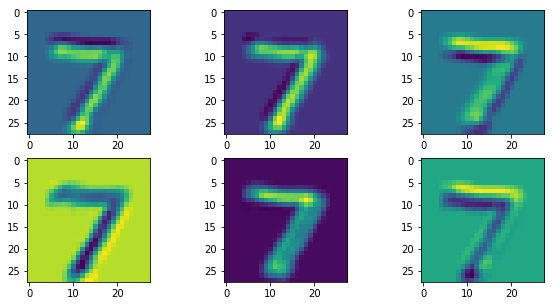

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

input_img = next(iter(test_loader))[0][0].unsqueeze(0)

def quantize_arr(arr):
    ''' Quantization based on linear rescaling over min/max range.'''
    min_val, max_val = np.min(arr), np.max(arr)

    if max_val - min_val > 0:
        quantized = np.round(255 * (arr - min_val) / (max_val - min_val))
    else:
        quantized = np.zeros(arr.shape)

    quantized = quantized.astype(np.uint8)
    min_val = min_val.astype(np.float32)
    max_val = max_val.astype(np.float32)

    return quantized, min_val, max_val
  
plt.figure(figsize=(10, 5))
row = 2
columns = 3
for i in range(6):
    output, min_val, max_val = quantize_arr(
        model.conv1.forward(input_img)[0][i].detach().numpy())
    plt.subplot(3 / columns + 1, columns, i + 1)
    plt.imshow(output)
    
